## Latent Space and Song Orders
We can now look at the trained samples in latent space. The latent space is a 2 dimensional representation of the wavesets ordered by similiarity. Each waveset is a point in the 2D space. We can think of a song as a series of jumps from waveset to waveset, i.e. a series of 2D coordinates. We want to save these series and train another network to create a new series.

In [1]:
from Variational_Autoencoder_alla_Valerio import VAE as Autoencoder
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import librosa.feature.inverse
from IPython.display import display, Audio

First we load the trained autoencoder and the training data from our disk:

In [2]:
subfolder = "0.25_16"
model_name = "VAE_vocals_128D_23927samples_20Epochs"
autoencoder = Autoencoder.load("data_and_models\\" + subfolder +"\\" + model_name)
autoencoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "Valerio"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 128, 16, 1)]      0         
_________________________________________________________________
encoder (Functional)         (None, 128)               1609312   
_________________________________________________________________
decoder (Functional)         (None, 128, 16, 1)        417505    
Total params: 2,026,817
Trainable params: 2,023,873
Non-trainable params: 2,944
_________________________________________________________________
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 128, 16, 1)] 0                                  

In [3]:
def load_data(subfolder):
    spectogram_data = np.load("data_and_models\\" + subfolder + "\\spectos.npy")
    song_labels = np.load("data_and_models\\" + subfolder + "\\song_labels.npy")
    position_labels = np.load("data_and_models\\" + subfolder + "\\position_labels.npy")
    print(spectogram_data.shape)
    
    return spectogram_data, position_labels, song_labels

x_train, y_train, y_train_alt = load_data(subfolder)

x_train = x_train[0:autoencoder.num_of_train_data]
y_train = y_train[0:autoencoder.num_of_train_data]
y_train_alt = y_train_alt[0:autoencoder.num_of_train_data]

(23927, 128, 16, 1)


## Data in latent space
We can now plot our wavesets in the latent space. Each waveset is reduced to a point in the 2 dimensional space. The distance between the points of two wavesets corresponds to their similarity. The colors represent at which position in a song the waveset occured (first 10% of the song, second 10% of the song and so on).

In [4]:
latent_representation = autoencoder.encoder.predict(x_train)

D:\Daten\Studium\Semester_7\MusikInfo\MetaHuman\venv\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


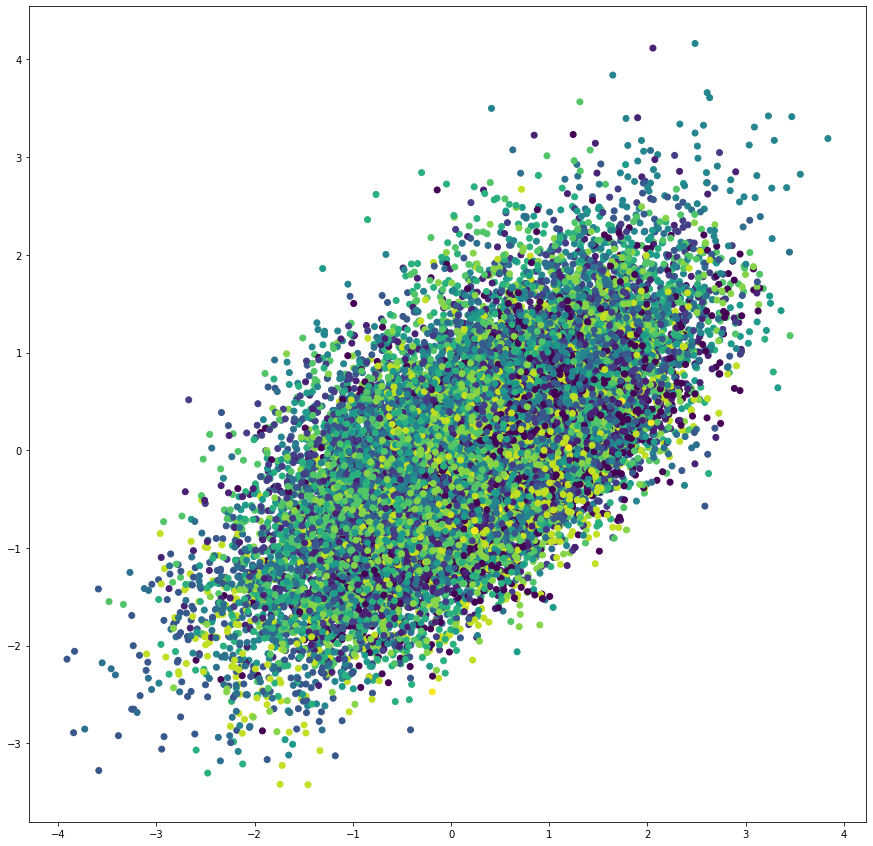

In [5]:
plt.figure(figsize=(15, 15))
plt.scatter(latent_representation[:, 0], latent_representation[:, 1], c=y_train)
plt.show()

## Generate Song Orders
A song is a series of wavesets. This series of wavesets corresponds to a list of coordinates in the latent space. It can be imagined as a movement - or more precisely a sequence of jumps - through the latent space. Later we want to use these sequences as training data for a second network. On their basis the second network will be able to produce new sequences. For this we need to store the series of coordinates for each song. We create a list of 2D arrays: first dimension is the song, and second dimension is the a tuple of coordinates.

In [7]:
num_of_ws_per_song = np.load("data_and_models\\" + subfolder + "\\SnippetNum.npy")

#ws_sums = np.cumsum(num_of_ws_per_song)
#num_of_ws_per_song = num_of_ws_per_song[:np.argwhere(ws_sums > x_train.shape[0]).min()]

start_ws = 0
stop_ws = 0
song_orders = []

for i, num_of_ws in enumerate(num_of_ws_per_song):
    stop_ws += num_of_ws
    song_order = latent_representation[start_ws : stop_ws]
    song_order = np.reshape(song_order, (num_of_ws, autoencoder.latent_space_dim))
    song_orders.append(song_order)
    start_ws += num_of_ws
    
song_orders = np.asarray(song_orders, dtype=object)
song_orders.shape

(22,)

We save the new list of song_orders on disk for later use:

In [8]:
save_path = "data_and_models\\" + subfolder + "\\" + str(autoencoder.model.name) +"_" + str(autoencoder.num_of_train_data)+"song_orders" + ".npy"
np.save(save_path,song_orders)

## The latent space representation of one song
We can plot the latent representation of a song. The subsequent wavesets are connected by lines to visualize, that the sequence of wavesets corresponds to a path trough the latent space.

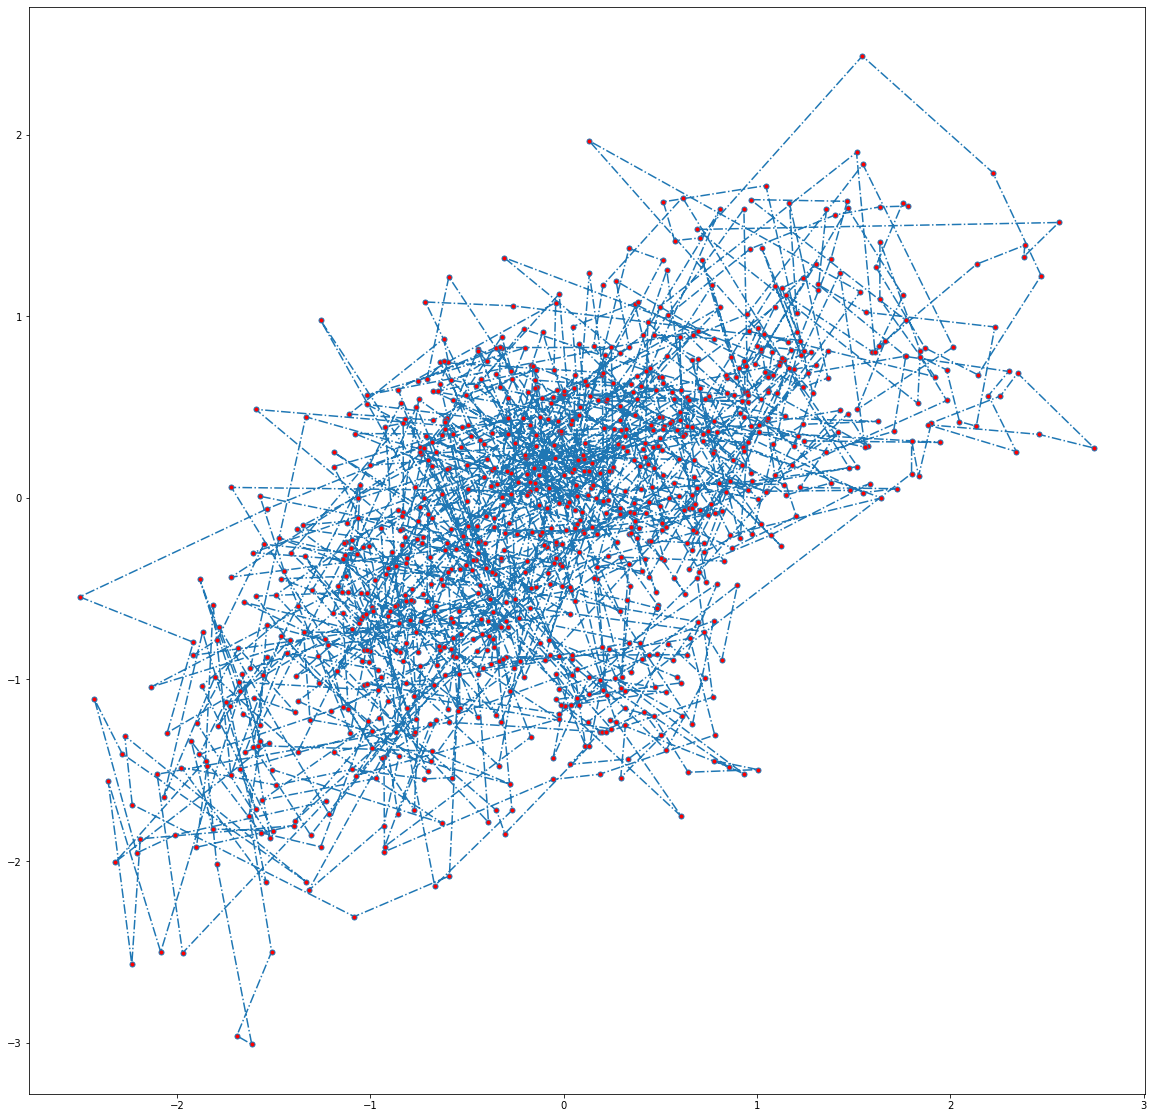

In [9]:
song_num = np.random.randint(0, num_of_ws_per_song.shape[0])
plt.figure(figsize=(20,20))
plt.plot(song_orders[song_num][:, 0], song_orders[song_num][:, 1], '-.o', markersize=5, markerfacecolor='red')
plt.show()

## Create a new Waveset
We can try the conversion, by let the autoencoder reconstruct a junk of audio. We feed the spectogram of the audio to the encoder to get it's latent representation. We can then test how much information gets lost in the autoencoder by passing the latent_representation to our decoder, which will spit out a spectogram. 
We can also try what happens, if we add a random offset to the latent representation. This can be imagined like a move away from the original latent space representation of the given spectogram. We thereby alter it. 

In [32]:
def reconstruct(data, max_offset, min_offset):
    latent_representations = autoencoder.encoder.predict(data)
    
    if max_offset>0:
        latent_representations += (np.random.rand(latent_representations.shape[0],latent_representations.shape[1]) * max_offset) + min_offset 
    
    reconstructed_ws = autoencoder.decoder.predict(latent_representations)
    reconstructed_ws = denormalise(reconstructed_ws,0,1, -100, 100)
    reconstructed_ws = np.clip(reconstructed_ws, -100,30)
    return reconstructed_ws

def denormalise(array, current_min, current_max, original_min, original_max):
        denorm_array = (array - current_min) / (current_max - current_min)
        denorm_array = denorm_array * (original_max - original_min) + original_min
        return denorm_array

def spectos_to_audio(spectos):
    signal = np.array(0)
    for i,specto in enumerate(spectos):
        reshaped_specto = specto[:, :, 0]
        lin_specto = librosa.db_to_power(reshaped_specto)
        pca = librosa.feature.inverse.mel_to_audio(lin_specto, sr=44100, hop_length=HOP_LENGTH, n_fft=N_FFT, win_length=WIN_LENGTH)
        signal = np.append(signal, pca)
        print(f"reconstructed {i+1} of {len(spectos)} wavesets.", end="\r")
    return signal

Original Specto:



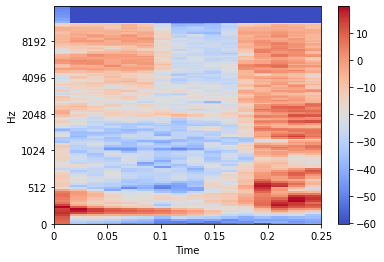

Reconstructed Specto:



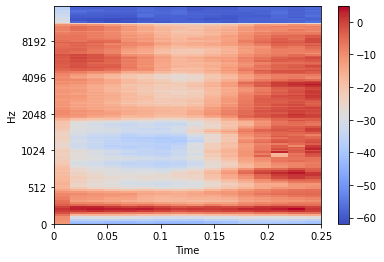

Reconstructed Specto with Offset in the Latent Space: 


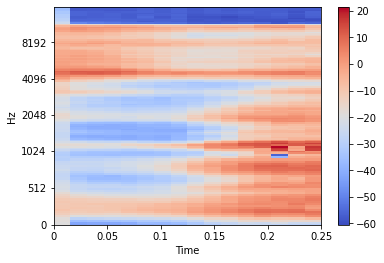

In [37]:
sr = 44100
WIN_LENGTH = 690*2
HOP_LENGTH = 690 
N_FFT = 690*2

def display_reconstructed_specto(index, max_offset, min_offset):

    reconstructed_ws = reconstruct(x_train[index:index+20],0,0)
    reconstructed_ws_offset = reconstruct(x_train[index:index+20], max_offset, min_offset)
    original_ws = denormalise(x_train[index:index+20],0,1,-100, 100)

    print("Original Specto:\n")
    librosa.display.specshow(
        original_ws[0].reshape(original_ws[0].shape[0],original_ws[0].shape[1]),
        x_axis='time',
        y_axis='mel',
        sr=44100,
        fmax=16000,
        hop_length=HOP_LENGTH,
    )
    plt.colorbar()
    plt.show()

    print("Reconstructed Specto:\n")
    librosa.display.specshow(
        reconstructed_ws[0].reshape(reconstructed_ws[0].shape[0],reconstructed_ws[0].shape[1]),
        x_axis='time',
        y_axis='mel',
        sr=sr,
        fmax=16000,
        hop_length=HOP_LENGTH,
    )
    plt.colorbar()
    plt.show()
    
    print("Reconstructed Specto with Offset in the Latent Space: ")
    librosa.display.specshow(
        reconstructed_ws_offset[0].reshape(reconstructed_ws_offset[0].shape[0],reconstructed_ws_offset[0].shape[1]),
        x_axis='time',
        y_axis='mel',
        sr=sr,
        fmax=16000,
        hop_length=HOP_LENGTH,
    )
    plt.colorbar()
    plt.show()

    return reconstructed_ws, reconstructed_ws_offset, original_ws

recon_ws, recon_ws_offset, original_ws = display_reconstructed_specto(np.random.randint(0,x_train.shape[0]), 3, 0.01)

In [4]:
original_signal = spectos_to_audio(original_ws)
print("\n This is the original Audio:")
display(Audio(original_signal,rate=44100))

NameError: name 'spectos_to_audio' is not defined

In [39]:
recon_signal = spectos_to_audio(recon_ws)
print("\n This is the reconstructed Audio:")
display(Audio(recon_signal,rate=44100))

reconstructed 20 of 20 wavesets.
 This is the reconstructed Audio:


In [40]:
recon_signal_offset = spectos_to_audio(recon_ws_offset)
print("\n This is the reconstructed Audio with Offset:")
display(Audio(recon_signal_offset,rate=44100))

reconstructed 20 of 20 wavesets.
 This is the reconstructed Audio with Offset:


We can sample random points in the latent space

In [27]:
random_points = np.random.rand(40, latent_representation.shape[1])
random_points = (random_points * 6) -3
random_spectos = autoencoder.decoder.predict(random_points)
random_spectos = denormalise(random_spectos,0,1, -100, 100)
random_spectos = np.clip(random_spectos, -100,30)
random_signal = spectos_to_audio(random_spectos)


KeyboardInterrupt



In [ ]:
display(Audio(random_signal,rate=44100))

In [41]:
original_signal.max()

159207.5